# Digit Recognition in Natural Images

We will be using google Street View Housing Number dataset for this project. The project is divided into  following sections:
 - Get data
 - Explore Data
 - Data Preprocessing
 - Model Training and validation
 - Test/Evaluation
 
To execute cell by pressing `shift` +  `enter`

In [10]:
import os
import sys
import tarfile
import numpy as np
from six.moves.urllib.request import urlretrieve
import scipy.io as sio
from six.moves import cPickle as pickle
import tensorflow as tf
from PIL import Image
from datetime import datetime
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

# GET DATA

In [5]:
url = 'http://ufldl.stanford.edu/housenumbers/'
last_percent_reported = None

def download_progress_hook(count, blockSize, totalSize):
    global last_percent_reported
    percent = int(count * blockSize * 100 / totalSize)
    
    if last_percent_reported != percent:
        if percent % 5 == 0:
            sys.stdout.write("%s%%" % percent)
            sys.stdout.flush()
        else:
            sys.stdout.write(".")
            sys.stdout.flush()
        
        last_percent_reported = percent


def maybe_download(filename, expected_bytes, force=False, dirc=""):
    d = False
    if force or not os.path.exists(dirc + filename):
        print ('Attempting to download: ' + filename)
        d = True
        filename, _ = urlretrieve(url + filename, dirc + filename, reporthook=download_progress_hook)
        print ('\nDownload Complete!')
    if not d:
        filename = dirc + filename
    statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print ('Found and verified', filename)
    else:
        raise Exception(
        'Failed to verify ' + filename + '. Can you get to it with a browser?')
    return filename

In [6]:
train_file = maybe_download('train_32x32.mat', 182040794, dirc="downloads/") #"downloads/train_32x32.mat"
test_file = maybe_download('test_32x32.mat', 64275384, dirc="downloads/") #"downloads/test_32x32.mat"

Found and verified downloads/train_32x32.mat
Found and verified downloads/test_32x32.mat


# DATA EXPLORATION

In [8]:
train_dataset = sio.loadmat(train_file)
test_dataset = sio.loadmat(test_file)

train_data, train_labels = train_dataset['X'], train_dataset['y']
test_data, test_labels = test_dataset['X'], test_dataset['y']

print( 'Train data:', train_data.shape,', Train labels:', train_labels.shape )
print( 'Test data:', test_data.shape,', Test labels:', test_labels.shape )

Train data: (32, 32, 3, 73257) , Train labels: (73257, 1)
Test data: (32, 32, 3, 26032) , Test labels: (26032, 1)


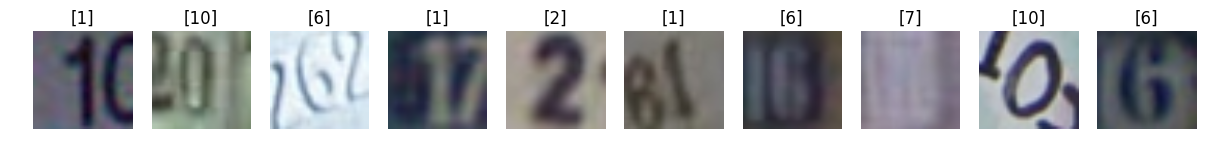

In [5]:
plt.rcParams['figure.figsize'] = (15.0, 15.0)
f, ax = plt.subplots(nrows=1, ncols=10)

for i, j in enumerate(np.random.randint(0, train_labels.shape[0], size=10)):
    ax[i].axis('off')
    ax[i].set_title(train_labels[j], loc='center')
    ax[i].imshow(train_data[:,:,:,j])

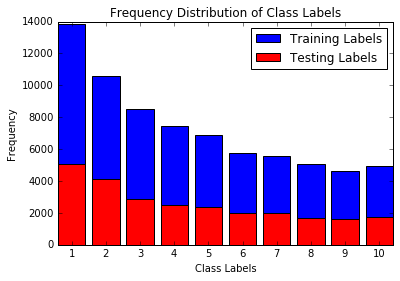

In [11]:
temp_labels = train_labels.reshape(73257).tolist()
temp_labels = dict(Counter(temp_labels))
plt.bar(range(len(temp_labels)), temp_labels.values(), align='center', label='Training Labels')
plt.xticks(range(len(temp_labels)), temp_labels.keys())
temp_labels = test_labels.reshape(26032).tolist()
temp_labels = dict(Counter(temp_labels))
plt.bar(range(len(temp_labels)), temp_labels.values(), align='center', color='red', label='Testing Labels')
plt.legend()
plt.xlabel('Class Labels')
plt.ylabel('Frequency')
plt.title('Frequency Distribution of Class Labels')
plt.show()

# DATA PREPROCESSING

In [6]:
# first we will normalize image data in range of -1 and 1.
train_data = train_data.astype('float32') / 128.0 - 1
test_data = test_data.astype('float32') / 128.0 - 1

# reshaping np array so that we can access data in CNN friendly format i.e. [i,:,:,:] from [:,:,:,i]
train_data = np.transpose(train_data, (3, 0, 1, 2))
test_data = np.transpose(test_data,(3, 0, 1, 2))

#chaning class labels range 1-10 to 0-9
train_labels[train_labels == 10] = 0
test_labels[test_labels == 10] = 0

# processing labels in CNN friendly format i.e. 1-hot-encoding
num_labels = 10
train_labels = train_labels[:,0]
test_labels = test_labels[:,0]
train_labels = (np.arange(num_labels) == train_labels[:, None]).astype(np.float32)
test_labels = (np.arange(num_labels) == test_labels[:, None]).astype(np.float32)

print 'Train data:', train_data.shape,', Train labels:', train_labels.shape
print 'Test data:', test_data.shape,', Test labels:', test_labels.shape

Train data: (73257, 32, 32, 3) , Train labels: (73257, 10)
Test data: (26032, 32, 32, 3) , Test labels: (26032, 10)


### Sanity Check

To make sure our data still looks good

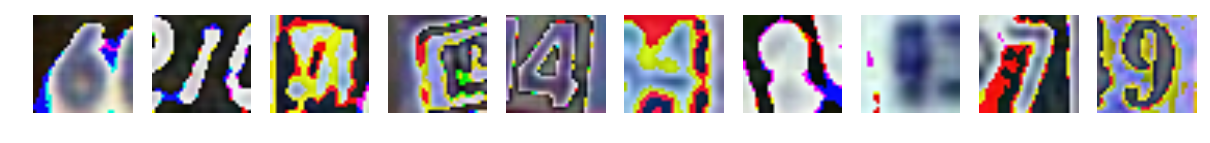

In [7]:
plt.rcParams['figure.figsize'] = (15.0, 15.0)
f, ax = plt.subplots(nrows=1, ncols=10)

for i, j in enumerate(np.random.randint(0, train_labels.shape[0], size=10)):
    ax[i].axis('off')
    # we will not display labels here as 1-hot-encoding cannot be viewed properly in little place
    ax[i].imshow(train_data[j,:,:,:])

#### Saving Data

The section below saves preprocessed data to svhn.pickle file in pickles directory

In [8]:
# creating dictionary to store trian and test data
svhn_datasets = {
    'train_dataset' : {
        'X': train_data,
        'y': train_labels
    },
    'test_dataset' : {
        'X': test_data,
        'y': test_labels
    }
}

data_file = 'pickles/svhn.pickle'

print 'saving pickle to %s' % data_file
with open(data_file, 'wb') as file:
    pickle.dump(svhn_datasets, file, protocol=pickle.HIGHEST_PROTOCOL)
    del svhn_datasets # to free up memory.

print 'pickle saved!'

saving pickle to pickles/svhn.pickle
pickle saved!


# MODAL TRAINIG AND VALIDATION

In [9]:
# lets load data from pickle file we previously stored
data_file = 'pickles/svhn.pickle' # redefined varaible in case you have completed above steps previously.
print 'Tring to load pickle from %s' % data_file
with open(data_file, 'rb') as file:
    svhn_datasets = pickle.load(file)
    train_dataset = svhn_datasets['train_dataset']
    test_dataset = svhn_datasets['test_dataset']
    del svhn_datasets # free up memory
print 'pickle loaded successfully!'

Tring to load pickle from pickles/svhn.pickle
pickle loaded successfully!


In [10]:
train_data = train_dataset['X']
train_labels = train_dataset['y']

test_data = test_dataset['X']
test_labels = test_dataset['y']

del train_dataset, test_dataset

print 'Test data:', test_data.shape,', Test labels:', test_labels.shape

Test data: (26032, 32, 32, 3) , Test labels: (26032, 10)


In [11]:
from sklearn.cross_validation import train_test_split

# splitting data in training and validation sets old school way
train_data, valid_data, train_labels, valid_labels = train_test_split(train_data, train_labels, 
                                                                      train_size=70000, random_state=106)

print 'Train data:', train_data.shape,', Train labels:', train_labels.shape
print 'Validation data:', valid_data.shape,', Validation labels:', valid_labels.shape

Train data: (70000, 32, 32, 3) , Train labels: (70000, 10)
Validation data: (3257, 32, 32, 3) , Validation labels: (3257, 10)


In [12]:
# helper methods for creating CNN
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],strides=[1, 2, 2, 1], padding='SAME')

In [13]:
graph = tf.Graph()

with graph.as_default():
    
    # placeholders for input data batch_size x 32 x 32 x 3 and labels batch_size x 10
    x = tf.placeholder(tf.float32, shape=[None, 32, 32, 3])
    y_ = tf.placeholder(tf.float32, shape=[None, 10])
    
    # defining decaying learning rate
    global_step = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(1e-4, global_step=global_step, decay_steps=10000, decay_rate=0.97)

    # Conv Layer 1: with 32 filters of size 5 x 5 
    W_conv1 = weight_variable([5, 5, 3, 32])
    b_conv1 = bias_variable([32])

    x_image = tf.reshape(x, [-1, 32, 32, 3])
    h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
    
    # Pool
    h_pool1 = max_pool_2x2(h_conv1)

    # Conv Layer 2:  with 64 filters of size 5 x 5 
    W_conv2 = weight_variable([5, 5, 32, 64])
    b_conv2 = bias_variable([64])

    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
    
    # Pool
    h_pool2 = max_pool_2x2(h_conv2)

    
    W_fc1 = weight_variable([8 * 8 * 64, 1024])
    b_fc1 = bias_variable([1024])
    
    # flatening output of pool layer to feed in FC layer
    h_pool2_flat = tf.reshape(h_pool2, [-1, 8*8*64])
    
    # FC layer
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

    # Dropout
    keep_prob = tf.placeholder(tf.float32)
    h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

    W_fc2 = weight_variable([1024, 10])
    b_fc2 = bias_variable([10])

    # Output
    y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

    cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_conv, y_))
    train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy, global_step)
    correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    saver = tf.train.Saver()

In [14]:
batch_size = 64
num_steps = 20001

print 'started traing at : ', str(datetime.now())
with tf.Session(graph=graph) as session:
    session.run(tf.initialize_all_variables())
    print 'Initialized'
    for i in xrange(num_steps):
        offset = (i * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_data[offset:(offset + batch_size), :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {x: batch_data, y_: batch_labels, keep_prob: 0.5}
        if i%500 == 0:
            train_accuracy = accuracy.eval(feed_dict={x:batch_data, y_: batch_labels, keep_prob: 1.0})
            valid_accuracy = accuracy.eval(feed_dict={x:valid_data, y_: valid_labels, keep_prob: 1.0})
            print("step: %d, training accuracy: %g, validation accuracy: %g" % 
                  (i,train_accuracy, valid_accuracy ))
        train_step.run(feed_dict={x: batch_data, y_: batch_labels, keep_prob: 0.5})
    print 'traing ended at : ', str(datetime.now())
    print 'saving trained model'
    save_path = saver.save(session, "saved_models/SVHN_MODEL.ckpt")
    print 'model saved!'
    session.close()
    print 'session closed!'

started traing at :  2016-10-06 14:48:23.268643
Initialized
step: 0, training accuracy: 0.140625, validation accuracy: 0.0859687
step: 500, training accuracy: 0.390625, validation accuracy: 0.466687
step: 1000, training accuracy: 0.671875, validation accuracy: 0.664108
step: 1500, training accuracy: 0.703125, validation accuracy: 0.737488
step: 2000, training accuracy: 0.78125, validation accuracy: 0.784771
step: 2500, training accuracy: 0.8125, validation accuracy: 0.816088
step: 3000, training accuracy: 0.828125, validation accuracy: 0.828984
step: 3500, training accuracy: 0.84375, validation accuracy: 0.833282
step: 4000, training accuracy: 0.859375, validation accuracy: 0.848941
step: 4500, training accuracy: 0.875, validation accuracy: 0.848634
step: 5000, training accuracy: 0.875, validation accuracy: 0.855081
step: 5500, training accuracy: 0.890625, validation accuracy: 0.865827
step: 6000, training accuracy: 0.90625, validation accuracy: 0.868898
step: 6500, training accuracy: 

# MODEL EVALUATION

In [15]:
batch_size = 3254
with tf.Session(graph=graph) as session:
    saver.restore(session, "saved_models/SVHN_MODEL.ckpt")
    test_accuracy = []
    for i in xrange(len(test_labels)/batch_size):
        batch_data = test_data[i * batch_size: (i * batch_size) + batch_size]
        batch_labels = test_labels[i * batch_size: (i * batch_size) + batch_size, :]
        test_accuracy.append(accuracy.eval(feed_dict={
                    x: batch_data, 
                    y_: batch_labels,
                    keep_prob: 1.0}))
    print 'test accuracy %g' % np.mean(test_accuracy)
    session.close()

test accuracy 0.892402
